# Example Notebook

This notebook serves to show how to create a notebook in the current directory structure.

Simply, after importing `init_notebook` the user can both import the `test_module` and its `test_function`, located in the `src` directory. Finally, it also becomes possible to open files in the `data` folder directly. All paths are relative to this directory so it is also possible to directly save a file to it.

In [1]:
import init_notebook
from test_module import test_function
import pca
from pca import PCAResult, plot_data_with_pcs

import numpy as np

test_function()

I was imported!


# Principal Component Analysis
We load the data from a file and perform PCA.

It's obvious that one of the principal components accounts for over 99.3% of the variance in the data, which motivates us to the assumption that the other principal component is just noise.

In [2]:
with open("pca_dataset.txt", 'r') as file:
    # Load data inta a Python ndarray, shape (100, 2)
    global data_matrix
    data_matrix = np.loadtxt(file, delimiter=' ')

pca_result = pca.pca(data_matrix)

U, S, Vh = pca_result
E = pca_result.energy

print(f'Energies: {str(E)}, sum: {np.sum(E)}, S: {S}')

Energies: [0.99314266 0.00685734], sum: 1.0, S: [9.94340494 0.82624201]


# Reversing PSA to verify correctness

In [3]:
data_matrix_centered = pca_result.reverse_pca()

# Before and after: Works nicely!
display_side_by_side = False
if display_side_by_side:
    for o, r in zip(data_matrix - data_matrix.mean(axis=0), data_matrix_centered):
        print(f'o: {o}, r: {r}')

assert np.allclose(data_matrix - data_matrix.mean(axis=0), data_matrix_centered)

# Plotting data

The plot looks suspiciously linear, which further supports the assumption that a linear model is very suitable for this dataset. The green principal component seems to be just noise, with no discernable patterns. The points align strongly with the red principal component.

PSA is a great approach for data that shows affine-linear behavior, as opposed to data on curved manifolds. This is why it makes sense to use PSA for this data.

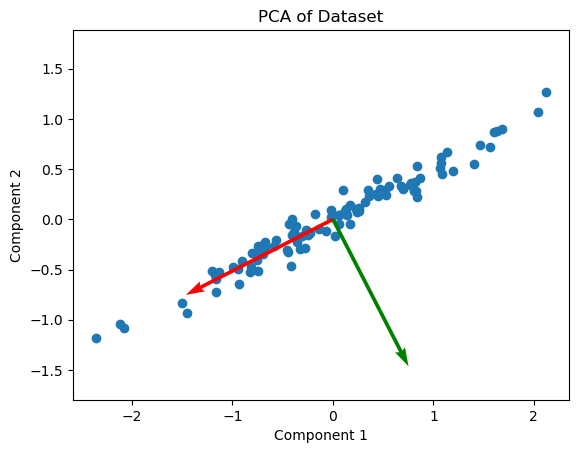

In [4]:
plot_data_with_pcs(data_matrix_centered, Vh)

# Approximate 1D

Eliminating the lesser principal component and approximating the data with only the first principal component, the data is approximated to a 1D line. This is done by simply setting the second singular value to 0 inside the matrix of singular values given by `S`, and then reversing the PCA by multiplying the matrices `U`, `S`, and `Vh`.

[[ 1.53045505  0.78668673]
 [-0.62493122 -0.32122805]
 [-0.57520496 -0.29566769]
 [-1.10916715 -0.57013571]
 [ 0.74950565  0.38526199]
 [-2.34798061 -1.20691241]
 [ 1.69852504  0.87307831]
 [-0.86209398 -0.4431348 ]
 [ 0.23994602  0.1233374 ]
 [-0.31307262 -0.16092604]
 [ 1.33149254  0.68441573]
 [-2.10203166 -1.08048937]
 [-0.35262484 -0.18125673]
 [-0.48326211 -0.24840709]
 [ 1.07510875  0.55262896]
 [-1.2134272  -0.62372762]
 [-0.23946851 -0.12309195]
 [-1.0049998  -0.51659146]
 [ 0.02111909  0.01085567]
 [ 0.52966817  0.2722608 ]
 [-1.16179542 -0.59718777]
 [ 1.04023015  0.53470061]
 [ 0.8817907   0.45325934]
 [ 0.51316048  0.2637755 ]
 [ 0.75372604  0.38743135]
 [-0.69601841 -0.3577684 ]
 [-0.12246057 -0.06294736]
 [-0.98314129 -0.50535571]
 [-0.38157216 -0.19613628]
 [ 0.49598488  0.25494687]
 [-0.76152365 -0.3914395 ]
 [-0.48549657 -0.24955565]
 [-0.79971833 -0.41107238]
 [-0.88445266 -0.45462764]
 [-0.70163441 -0.36065514]
 [-0.10439467 -0.0536611 ]
 [-1.15622429 -0.59432409]
 

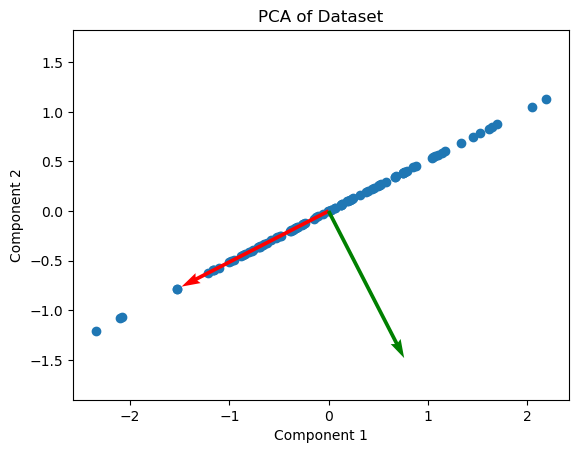

In [5]:
approximated_data = pca_result.reverse_pca(1)

print(approximated_data)

plot_data_with_pcs(approximated_data, pca_result.Vh)